In [1]:
# attemp on HW1_2_2 - MADE

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.nn import init
import torch.nn as nn
from torch.autograd import Variable

import pdb

In [3]:
device = torch.device("cuda:0")

In [4]:
data = np.load('distribution.npy')

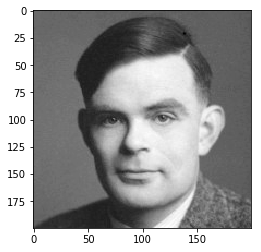

In [5]:
plt.imshow(data, cmap='gray')

In [6]:
# check that it's a probability distribution
np.sum(data)

1.0

how to sample from it?
there may be a method to sample from this distribution (https://www.mathworks.com/matlabcentral/fileexchange/35797-generate-random-numbers-from-a-2d-discrete-distribution)
but here I follow https://github.com/ikrets/CS294-158-homeworks/blob/master/HW1_2_1.ipynb
draw uniformly distributed samples

In [7]:
samples = np.random.choice(200 * 200, p=data.reshape(-1), size=100000)
x = samples % 200
y = samples // 200
samples = np.stack([x, y], axis=1)
train, valid = samples[:np.int32(0.8 * len(samples))], samples[np.int32(0.8 * len(samples)):]
print('train.shape = ', train.shape)
print('valid.shape = ', valid.shape)

train.shape =  (80000, 2)
valid.shape =  (20000, 2)


how to design the net?
two distributions: $p(x1)$ and $p(x2 | x1)$ where $p(x2, x1) = p(x2|x1) p(x1)$. 

$p(x1)$ is just a vector of random variables from the softmax $\exp(\theta) / \sum_i(exp(\theta_i))$

what is p(x2 | x1)??? 

Build a dense net that takes as input the training x1 and produces x2.

The network will not produces x2, it will output a probability p(x2|x1).
We will minimize this probability : p(x2|x1)*p(x1) using the nll
so x1 is the input of the net and p(x2|x1) is the output.

Be aware that x2 must depends on x1 only and must not depend on x2.

For this configuration, this is not a real problem since x1 are rows and x2 are column and then they are independents

In [8]:
# learning rate
learning_rate = 3.0e-4

# numpber of samples
n_samples = 200

# simple MADE:
# harnessing a dense neural network to produce a probability by enforcing the output random variable
# to be dependent 
# masked the linear linear A * X + b into M . W * X + b where M is a mask
# 
# NOTES: 1. the linear model is adapted from: https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html
#        2. the maks computation is adapted from https://github.com/karpathy/pytorch-made 
class MADE(nn.Module):
    def __init__(self, inout_features, hidden_features, num_hidden_layers):
        super(MADE, self).__init__()
        
        # assert 
        assert hidden_features >= inout_features, 'number of hidden features is lower than number of in/out features'
        
        # number of input features
        self.inout_features = inout_features
        
        # number of output features
        self.hidden_features = hidden_features
        
        # number of hidden layers
        self.num_hidden_layers = num_hidden_layers        
        
        # weights + bias
        self.weight = []
        self.bias = []
        
        # input to hidden layers
        for l in range(num_hidden_layers):
            self.weight.append(Parameter(torch.Tensor(self.hidden_features, inout_features)))
            self.bias.append(Parameter(torch.Tensor(self.hidden_features)))
            inout_features = self.hidden_features   
            
        # last layers
        self.weight.append(Parameter(torch.Tensor(self.inout_features, self.hidden_features)))
        self.bias.append(Parameter(torch.Tensor(self.inout_features)))
        
        # init layers
        self.reset_parameters()
        
        # calculate masks
        self.calculate_masks()
        
    def reset_parameters(self):
        
        for l in range(len(self.weight)):
            init.kaiming_uniform_(self.weight[l], a=math.sqrt(5))
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight[l])
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias[l], -bound, bound)
            
    def calculate_masks(self):
        
        m = {}
        
        # input features
        m[-1] = np.random.permutation(self.inout_features)
        
        # hidden layers
        for l in range(self.num_hidden_layers):
            m[l] = np.random.randint(m[l-1].min(), self.inout_features - 1, self.hidden_features)

        # build corresponding hidden masks
        self.masks = []
        for l in range(len(m)):
            self.masks.append((m[l-1][:, None] <= m[l][None, :]).astype(np.float32))
            
        # build last mask (last hidden to output)
        self.masks.append((m[self.num_hidden_layers - 1][None, :] < m[-1][:, None]).astype(np.float32))
        
        for l in range(self.masks):
            self.masks[l] = torch.from_numpy(self.masks[l])
        
    def forward(self, x):
        
        for l in range(len(self.weight) - 1):
            x = F.linear(x, self.masks[l] * self.weight[l], self.bias[l])
            x = F.relu(x)
            
        x = x.pop()
        
        return x
        
        

# training loop
1. grab a batch
2. forward:
   calculate p(x1): p_x1 = torch.exp(thetas) / torch.sum(torch.exp(thetas))
   calculate p(x2 | x1): nade(x1)
3. calculate the loss: 
   calculate loss = sum(-ln(p(x2 | x1) * p(x1)) / n_samples
4. zero gradients
5. backward: loss.backward()
6. update gradients ~ accumulate (no grads)
7. goto 1.